# Organization of notebook

1. Imports<br>
2. Semi-analytic ($M_{crit}$ business) _functions only_<br>
    a. all functions -- serve to determine "analytic" limits<br>
3. Numerical (CLASS-based) _functions only_<br>
    a. make_inis -- makes ini files for given mass, power, etc.<br>
    b. calculate_kcuts, fit_fun, sigma0 limits -- used for getting numerical upper lims on sigma0<br>
    c. findLocalMins, findLocalMaxs -- give peaks/troughs of Tk<br>
    d. tk -- gives transfer function<br>
    e. peaks -- gets locations/amplitudes peaks of oscillatory business<br>
4. Analysis (limits)<br>
    a. Semi-analytic limits<br>
    b. Sanity check on analytics using CLASS<br>
    c. Limits via exclusion curves<br>
    d. Semi-analytic, conservative, CMB limits<br>
    e. Tables of limit values for each n<br>
5. Analysis (tk/DAOs)<br>
    f. Tk for single sigma<br>
    g. Tks for full sigma range<br>
    h. First peak amplitude<br>
    i. Peaks for same cross section<br>
    j. First, second, third peaks<br>
    k. Ratio of first to second peaks<br>

# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

---

---

---

# Semi-analytical functions

#### Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [2]:
# Constants
h = 0.6727
H0 = 67.27
Omega_m = 0.26495
Omega_b = 0.05
Omega_rad = 10e-5
p_crit = 4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p = 0.93827231
Y_p = 0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
Rx_conerverionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

#### Relevant functions

https://arxiv.org/pdf/1801.08609.pdf

$ N_0 =  2^{(5+n)/2}\Gamma(3+n/2)/(3\sqrt{\pi})$

In [3]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

$M_{hm} = \frac{4\pi\bar{\rho}}{3}\big(\frac{\lambda_{hm}}{2}\big)^3$

$\qquad = \frac{4\pi\bar{\rho}}{3}\big(\frac{\pi}{hk_{hm}}\big)^3$

$\therefore k_{hm} = \frac{\pi}{h}\big(\frac{4\pi\bar{\rho}}{3M_{hm}}\big)^{1/3}$

In [4]:
def mhm2khm(Mhm):
    return np.pi/h*(((4.*np.pi*rho_crit)/(3*Mhm))**(1./3.))

https://arxiv.org/pdf/1808.00001.pdf

$Rx_noZ = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0}{m_p}+\frac{T_{0}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$


In [5]:
def Rx_noZ(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0/m_x)+(T_0/m_p),((1.+n)/2.)))

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))$

Note that $aH \sim z$ and $R_{\chi} \sim z^{n+5/2}$ such that

$zH_0\sqrt{\Omega_{rad}} = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))z^{n+5/2}$

$\therefore z = ((m_{\chi}+m_p)H_0\sqrt{\Omega_{rad}}/R_{\chi}m_{\chi})^{2/n+3}$

In [6]:
def z_th(sigma_0,m_x,n):
    return ((H0*np.sqrt(Omega_rad)*(m_x+m_p))/(Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

Note that $aH \sim z$, $a\bar{\rho} \sim z^2$, $T_b \sim z$ and $T_{\chi} \sim z^2/z_{th}$, such that

$\frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0} = z^2/z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2}$

$0 = z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2} - \frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0}$

Solving the above for $z$ yields $z_{kin}$

In [7]:
def z_kin(sigma_0,m_x,n):
    return fsolve(lambda z: z * ((T_0*z**2)/(z_th(sigma_0,m_x,n)*m_x) + (T_0*z_th(sigma_0,m_x,n))/m_p)**((n+1.)/2.) - (H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*Rx_conerverionFactor))*(m_x+m_p)/sigma_0,z_th(sigma_0,m_x,n)/2.)    

https://arxiv.org/pdf/1904.10000

$k_{crit} = aH = H_0\sqrt{\Omega_{rad}}z_{kin}^2/z_{kin} = H_0\sqrt{\Omega_{rad}}z_{kin}$

In [8]:
# Equation 4
def sigma2k(sigma_0,m_x,n):
    return (H0*np.sqrt(Omega_rad)*z_kin(sigma_0,m_x,n))*3.33e-6

# Equation 4
def sigma2k2(sigma_0,m_x,n):
    return (H0*np.sqrt(Omega_rad)*z_th(sigma_0,m_x,n))*3.33e-6

https://arxiv.org/pdf/1808.00001.pdf

$R_{x,kin} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0z_{th}}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\Big)^{\frac{1+n}{2}}$

In [9]:
def Rx_kin(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0*pow(z_kin(sigma_0,m_x,n),2))/(m_x*z_th(sigma_0,m_x,n))+((T_0*z_th(sigma_0,m_x,n))/m_p),((1.+n)/2.)))

https://arxiv.org/pdf/1808.00001.pdf

$R_{x,th} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_0(1+z_{th})}{m_p}+\frac{T_0(1+z_{th})}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

In [10]:
def Rx_th(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow(((T_0*(1+z_th(sigma_0,m_x,n)))/(m_x))+((T_0*(1+z_th(sigma_0,m_x,n)))/m_p),((1.+n)/2.)))

$\sigma_0$ $limits$

In [11]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

---

---

---

# Numerical functions

In [12]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
smallSigs2 = np.logspace(-17,-30,100)
largeSigs = np.logspace(-10,-30,100)

#### Generate inis

In [13]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,masses=masses_test,sigmas=smallSigs,output_path='pk_output',sh_file='class/run_classes.sh'):
    
    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    fout_sh = open(class_runner_path+'run_classes.sh', 'w')

    for m in masses:
        for sigma in sigmas:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')
            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [14]:
make_inis(npow=8,masses=[0.0001],sigmas=smallSigs)

From the command line, run:

chmod +x run_classes.sh

bash run_classes.sh

$\sigma_0$ $limits$

In [15]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=smallSigs, pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk_130.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    khms = []
    ss = []
        
    for i,sigma in enumerate(sigmas):
        try:
            data = np.loadtxt(pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z))
            pk = data[:,1]
            ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
            if ks[ind]>upper_cut or ks[ind]<lower_cut:
                continue
            khms.append(ks[ind])
            ss.append(sigmas[i])
        except:
            continue
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    return np.array(ss),np.array(khms),p

In [16]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [17]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        np.loadtxt(ks_filename)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                  
    return masses,sigmas

#### $T(k)_{idm}$

In [18]:
def findLocalMins(arr):
    mins = []
    i=0
    while i < len(arr):
        try:
            if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                mins.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
         
    return mins

In [19]:
def findLocalMaxs(arr):
    maxs = []
    i=0
    while i < len(arr):
        try:
            if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                maxs.append(i)
            i+=1
        except:
            i+=1
            continue
                
    return maxs

In [20]:
def single_tk(npow=0,m=0.0001,plotPeaks=False,pltType='none',
              index=0,sigmas=smallSigs,lw=2.5,label='',clr='none'):

    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    for i,sigma in enumerate(sigmas):
        # Index of interest
        if i!=index:
            continue
        sig=sigma
        print sigma
        # pk data from class for given mass, sigma, power
        filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
        np.loadtxt(filename)
        data = np.loadtxt(filename)
        pk = data[:,1]

        if pltType=='cons':
            clr = '#D81B60'
            lbl = "$\sigma_{0,c}=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
        elif pltType=='analytic':
            clr = '#63acbe'
            lbl = "$\sigma_{0,a}=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
        else:
            clr = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)
            lbl = "$\sigma_0=$"+str(' {:.1e}'.format(float(sigma)))+" cm$^2$"
            print (ks.shape,pk.shape,pk0.shape)
            plt.plot(ks,(pk)/pk0,linewidth=lw,linestyle='-',color=clr,label=lbl)
                    
    return (pk)/pk0,ks,sig

In [21]:
def all_tk(npow=0,m=0.0001,sigmas=smallSigs,z='z1',
           colorbar=False,pk_root='class/pk_output/',
            filename=None,label='',lw=0.3):
    
    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    colors = [(math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10),(math.sqrt((1.))/10,1-math.sqrt((1.))/10,1-math.sqrt((1.))/10)]  # R -> G -> B
    n_bins = [100]  # Discretizes the interpolation into bins
    cm = LinearSegmentedColormap.from_list('cm', colors, N=100)

    for i,sigma in enumerate(sigmas):
        try:
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            if npow==1: c='y'
            if npow==2: c='r'
            if npow==3: c='b'
            if npow==4: c='g'
            if npow==5: c='k'
            if npow==6: c='m'
            if npow==8: c='olive'                    
            if npow==10: c='c'
            if colorbar: c = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            plt.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=0.5) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001)
        except: continue
    
    if colorbar:          
        tick_locs = [1e-30,1e-20]
        tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
        cb = plt.colorbar(sc, orientation="vertical")
        cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        cb.update_ticks()
        cb.ax.tick_params(labelsize=40,length=15,width=3,color='w')
        cb.ax.locator_params(nbins=2)

In [22]:
def peaks(npow=2,m=0.0001,sigmas=smallSigs2):
    
    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]

    k_peaks = []
    tk_peaks = []
    sigggs = []

    for i,sigma in enumerate(sigmas):
        try:
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/' + 'n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]

            # determine peaks/troughs of transfer
            a = pk/pk0
            mins = findLocalMins(a)
            maxs = findLocalMaxs(a)

            k_peaks1D = [[],[],[]]
            tk_peaks1D = [[],[],[]]
            k=0        
            for j in range(len(maxs)):
                k_peaks1D[k].append(ks[maxs[j]])
                tk_peaks1D[k].append(pk[maxs[j]]/pk0[maxs[j]])
                if j != len(maxs)-1:
                    if maxs[j+1]-maxs[j]>2:
                        k+=1

            for l in range(k+1):
                if k_peaks1D[l]:
                    k_peaks1D[l] = np.average(k_peaks1D[l])
                    tk_peaks1D[l] = np.average(tk_peaks1D[l])  
            
            if k_peaks1D[0]:     
                k_peaks.append(k_peaks1D)
                tk_peaks.append(tk_peaks1D)
                sigggs.append(sigma)
        
        except: continue
        
    return k_peaks, tk_peaks, sigggs

---

---

---

# Plots/Analysis (limits)

#### Semi-analytical limits

Derivation of upper limits on cross section using analytical formalism presented a little while back

(1e-30, 1e-11)

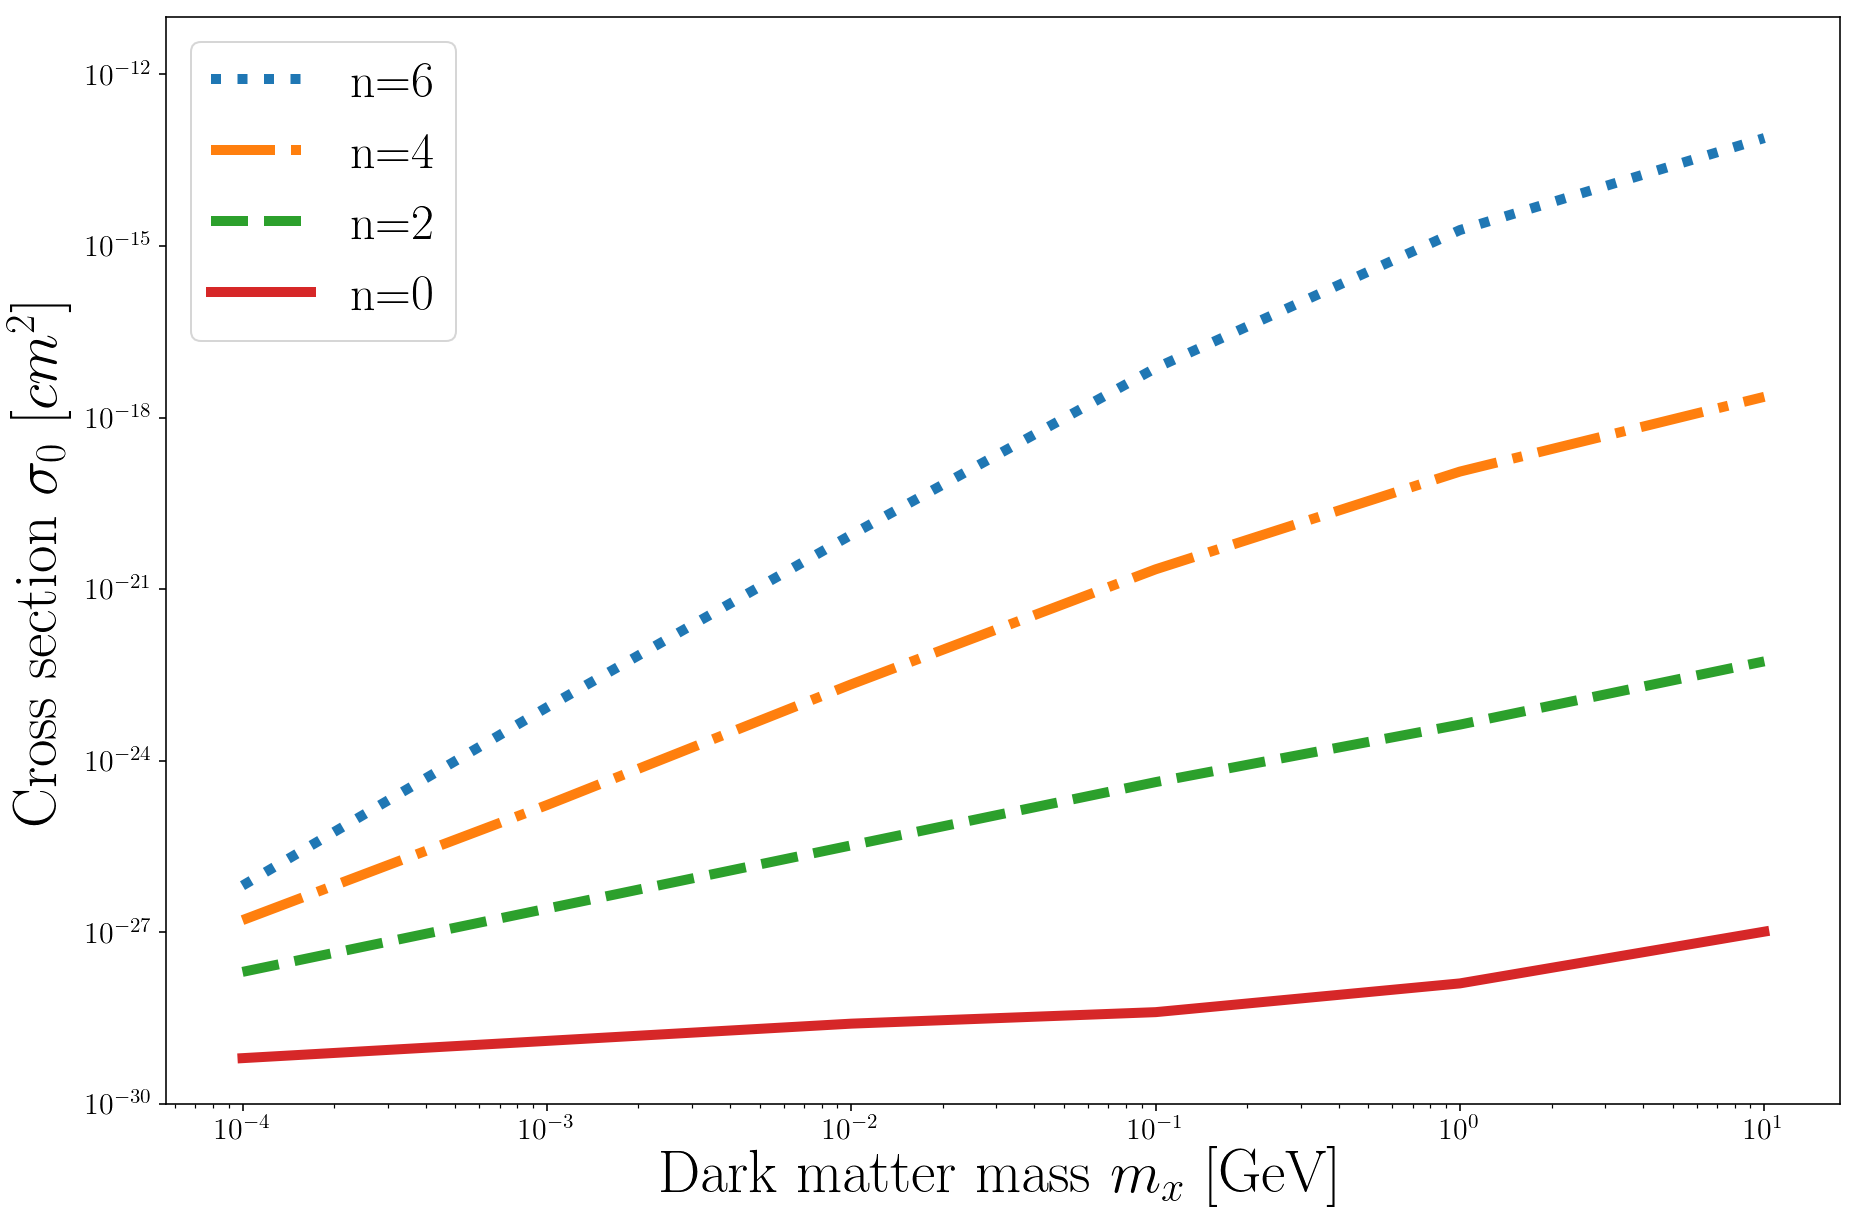

In [23]:
klim = mhm2khm(3*10**8)
# klim=0.1
plt.figure(figsize=(15,10))

plt.loglog(masses, sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses, sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses, sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses, sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

# plt.savefig("analytical.png")

#### Numerical limits

Derivation of numerical limits using modified version of CLASS. **Note** that this does not work unless shapes are broadcast to (130,). This requires the commenting out of class/inis/dmeff_base_ini $\rightarrow$ k_per_decade... in addition to the utilization of lambda_pk_z1_130.dat instead of lambda_pk_z1.dat 

In [24]:
npow_=6

In [25]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

In [26]:
sigmas_ref = np.logspace(-10,-30,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

In [27]:
masses0,sigmas0=sigma0_limit(kcut=36,npow=0)
masses2,sigmas2=sigma0_limit(kcut=36,npow=2)
masses4,sigmas4=sigma0_limit(kcut=36,npow=4)
masses6,sigmas6=sigma0_limit(kcut=36,npow=6)

(1e-30, 1e-11)

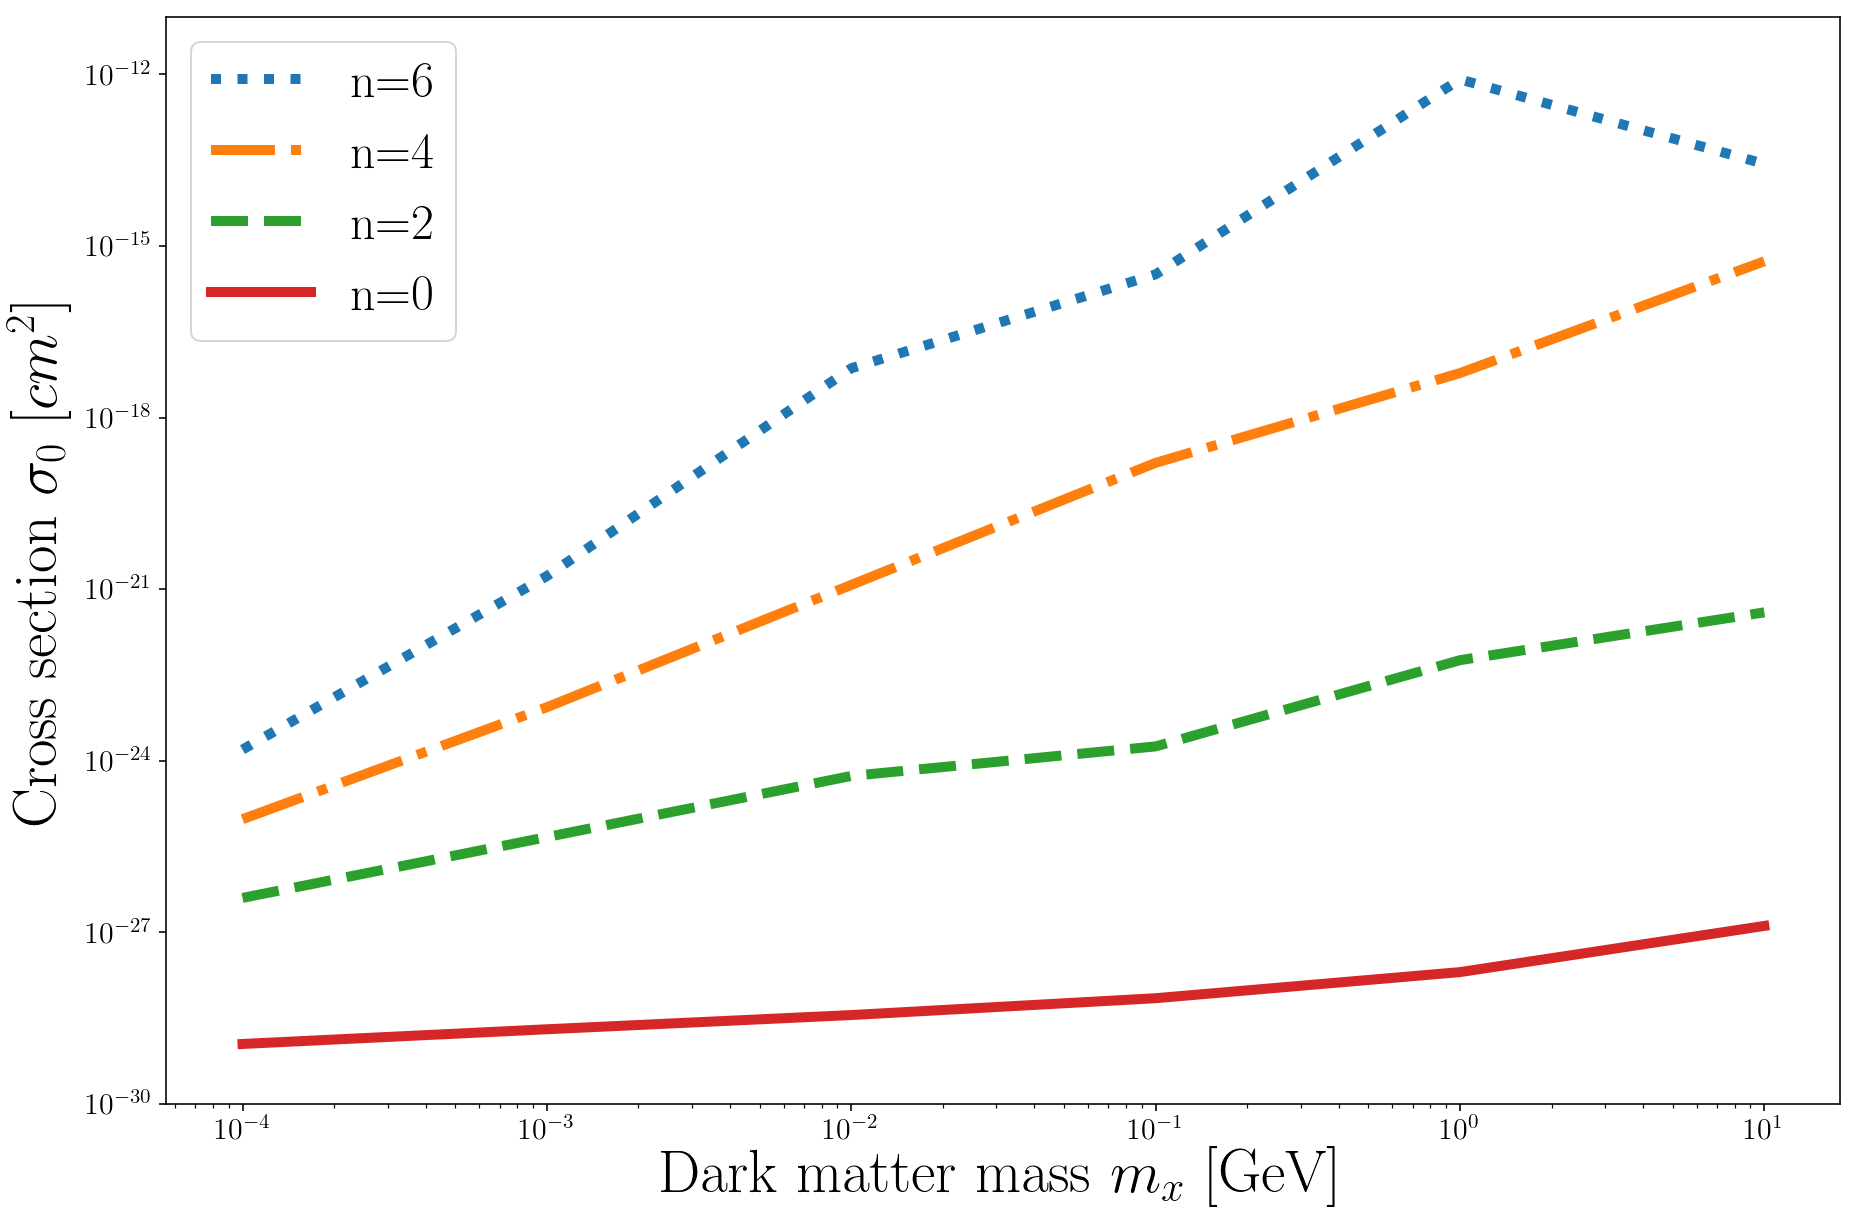

In [28]:
plt.figure(figsize=(15,10))

plt.loglog(masses6,sigmas6, label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses4,sigmas4, label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses2,sigmas2, label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses0,sigmas0, label="n=0",linewidth=5)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

# plt.savefig("numerical.png")

#### Limits by exclusion curve

In [29]:
def transfer(k,mwdm):
    nu = 1.12
    lambda_fs = (0.049*(mwdm**(-1.11))\
                 *((Omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    alpha = lambda_fs
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

3.5111917342151417e-26
2.1049041445120304e-28


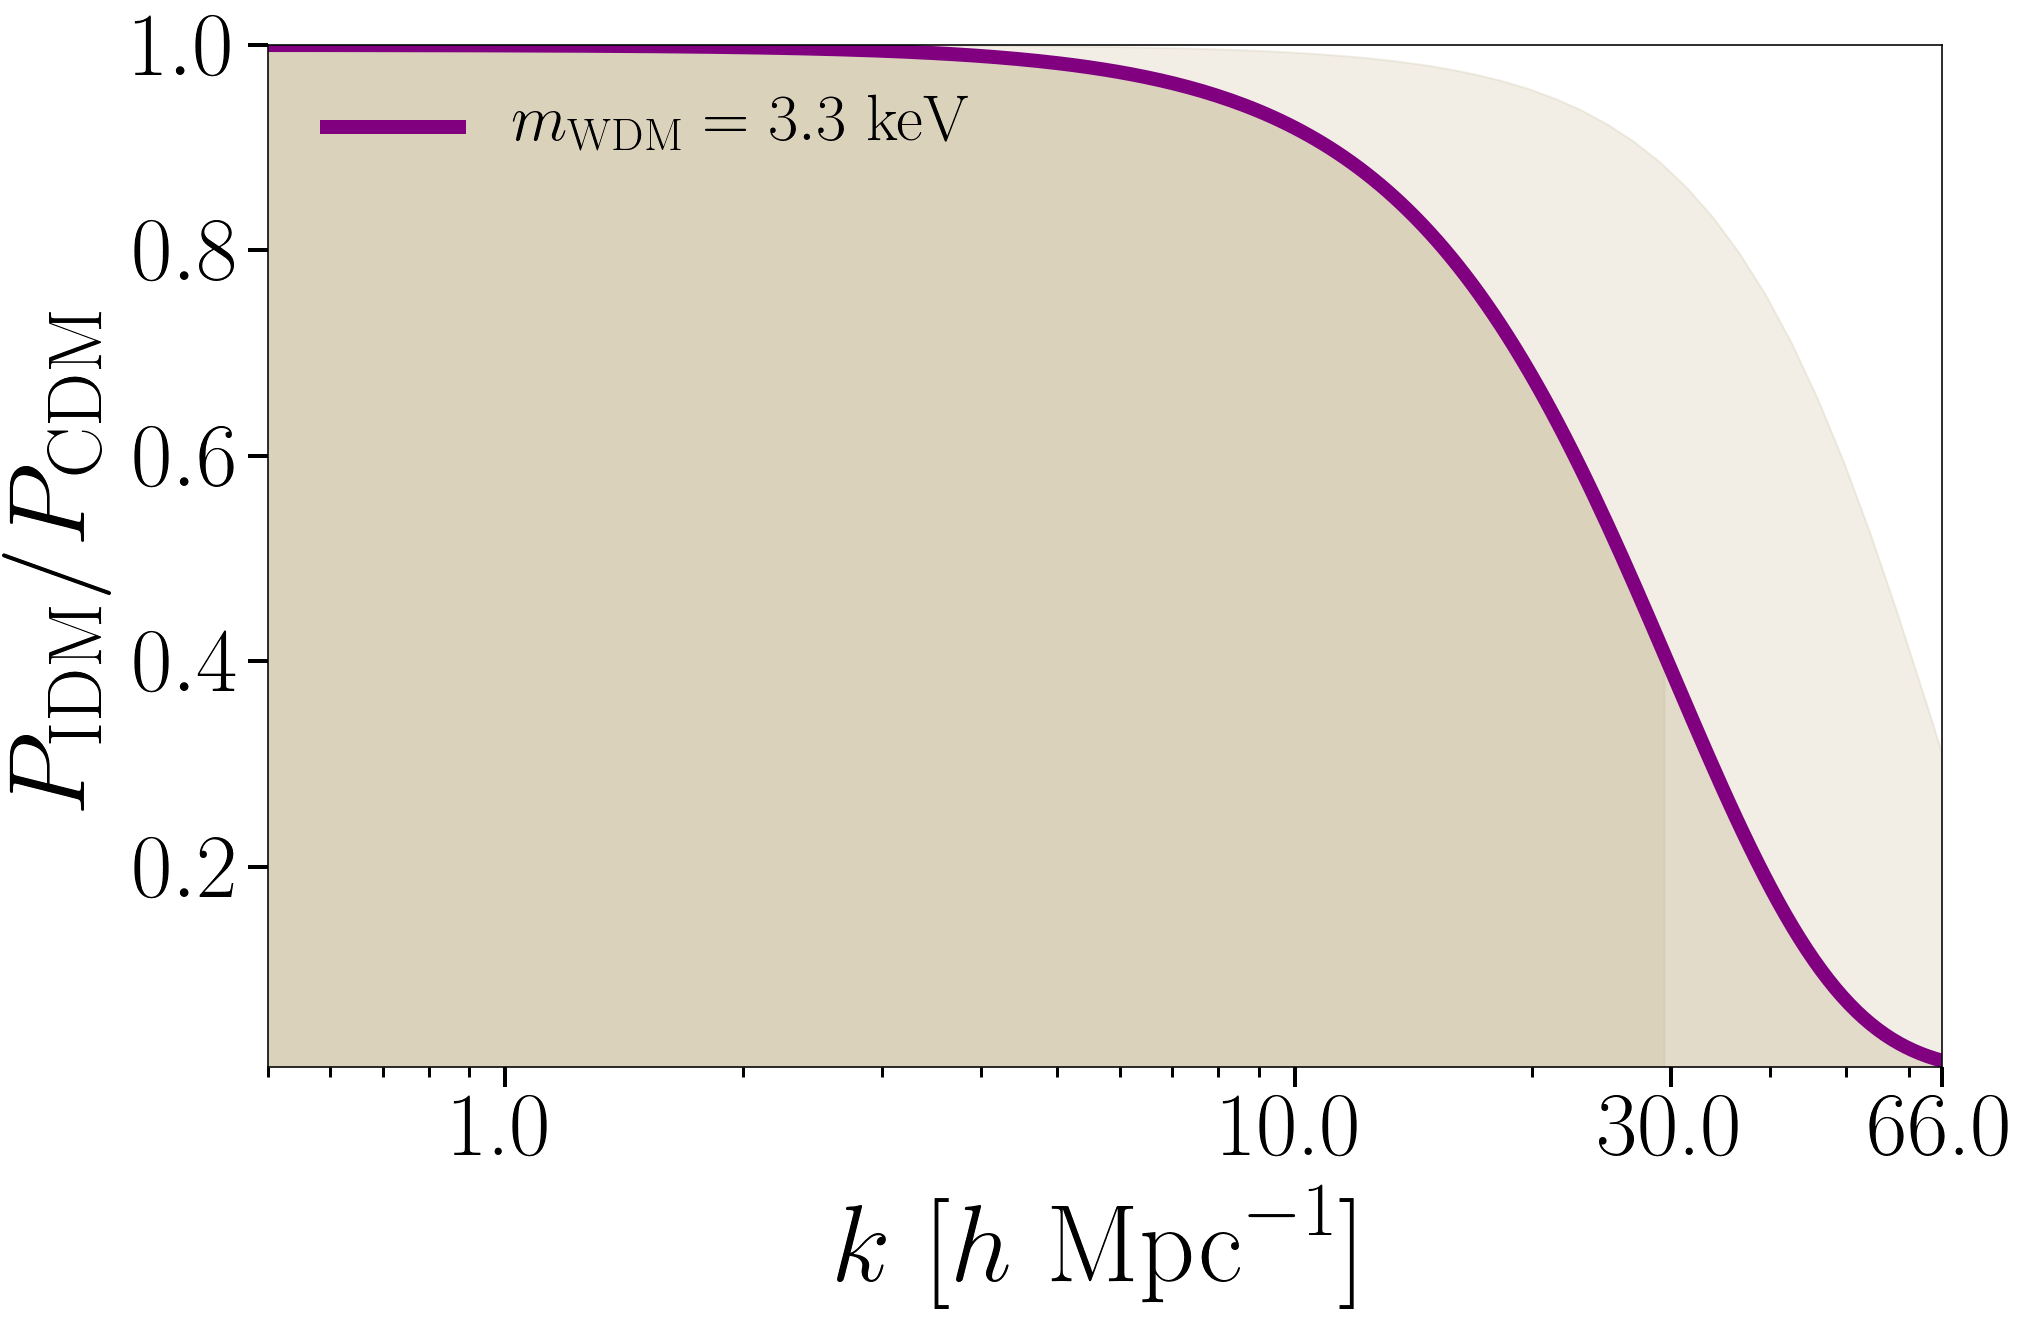

In [30]:
ks2 = np.logspace(-5,4,1000)

plt.figure(figsize=(15,10))

plt.semilogx(ks2,transfer(ks2,3.3)**2,linestyle='-',label=r'$m_{\rm{WDM}} = 3.3\ \rm{keV}$',c='#800080',lw=7)

# tk_idm,ks,sigma0 = single_tk(npow=6,m=1,pltType='cons',sigmas=np.logspace(-5,-30,100),index=15,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=6,m=1,pltType='analytic',sigmas=np.logspace(-5,-30,100),index=39,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=6,m=0.01,pltType='cons',sigmas=np.logspace(-10,-30,100),index=15,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=6,m=0.01,pltType='analytic',sigmas=np.logspace(-20,-30,100),index=1,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=6,m=0.0001,pltType='cons',sigmas=np.logspace(-20,-30,100),index=5,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=6,m=0.0001,pltType='analytic',sigmas=np.logspace(-20,-30,100),index=61,lw=7)

# tk_idm,ks,sigma0 = single_tk(npow=4,m=1,pltType='cons',sigmas=np.logspace(-10,-30,30),index=7,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=4,m=1,pltType='analytic',sigmas=np.logspace(-10,-30,30),index=13,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=4,m=0.01,pltType='cons',sigmas=np.logspace(-10,-30,100),index=40,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=4,m=0.01,pltType='analytic',sigmas=smallSigs,index=26,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=4,m=0.0001,pltType='cons',sigmas=smallSigs,index=33,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=4,m=0.0001,pltType='analytic',sigmas=smallSigs,index=67,lw=7)

tk_idm,ks,sigma0 = single_tk(npow=2,m=0.0001,pltType='cons',sigmas=smallSigs,index=54,lw=7)
tk_idm,ks,sigma0 = single_tk(npow=2,m=0.0001,pltType='analytic',sigmas=smallSigs,index=76,lw=7)

# tk_idm,ks,sigma0 = single_tk(npow=0,m=0.0001,pltType='analytic',sigmas=smallSigs,index=10,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=0,m=0.01,pltType='analytic',sigmas=smallSigs,index=1,lw=7)
# tk_idm,ks,sigma0 = single_tk(npow=0,m=1,pltType='analytic',sigmas=smallSigs,index=33,lw=7)

plt.fill_between(np.logspace(-5,4,1000), -10, transfer(ks2,3.3)**2,np.logspace(-5,4,1000) <=30,color='#ccbe9f',alpha=0.3)
plt.fill_between(np.logspace(-5,4,1000), -10, transfer(ks2,3.3)**2,color='#ccbe9f',alpha=0.40)
plt.fill_between(ks,tk_idm,0,color='#ccbe9f', alpha=0.25)

# plt.text(7.4,0.65,"Conservative",rotation=-72,fontsize=30,alpha=0.85)
# plt.text(21,0.65,"WDM",rotation=-64,fontsize=30,alpha=0.85)
# plt.text(41,0.75,"Analytic",rotation=-67,fontsize=30,alpha=0.85)

plt.xscale("log")
plt.xlim(0.5,66)
plt.ylim(0.005,1)
plt.ylabel(r'$P_{\rm{IDM}}/P_{\rm{CDM}}$',fontsize=55,labelpad=5)
plt.xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=55,labelpad=5)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)
plt.xticks([1e0,1e1,3e1,6.6e1],[1e0,1e1,3e1,6.6e1])
# plt.yticks([0.05,0.25,0.5,0.75,1.0])
plt.legend(fontsize=33,framealpha=0)

plt.subplots_adjust(bottom=0.17)
# plt.savefig("plots/exclusions/exclusion_n4_m100keV.png")

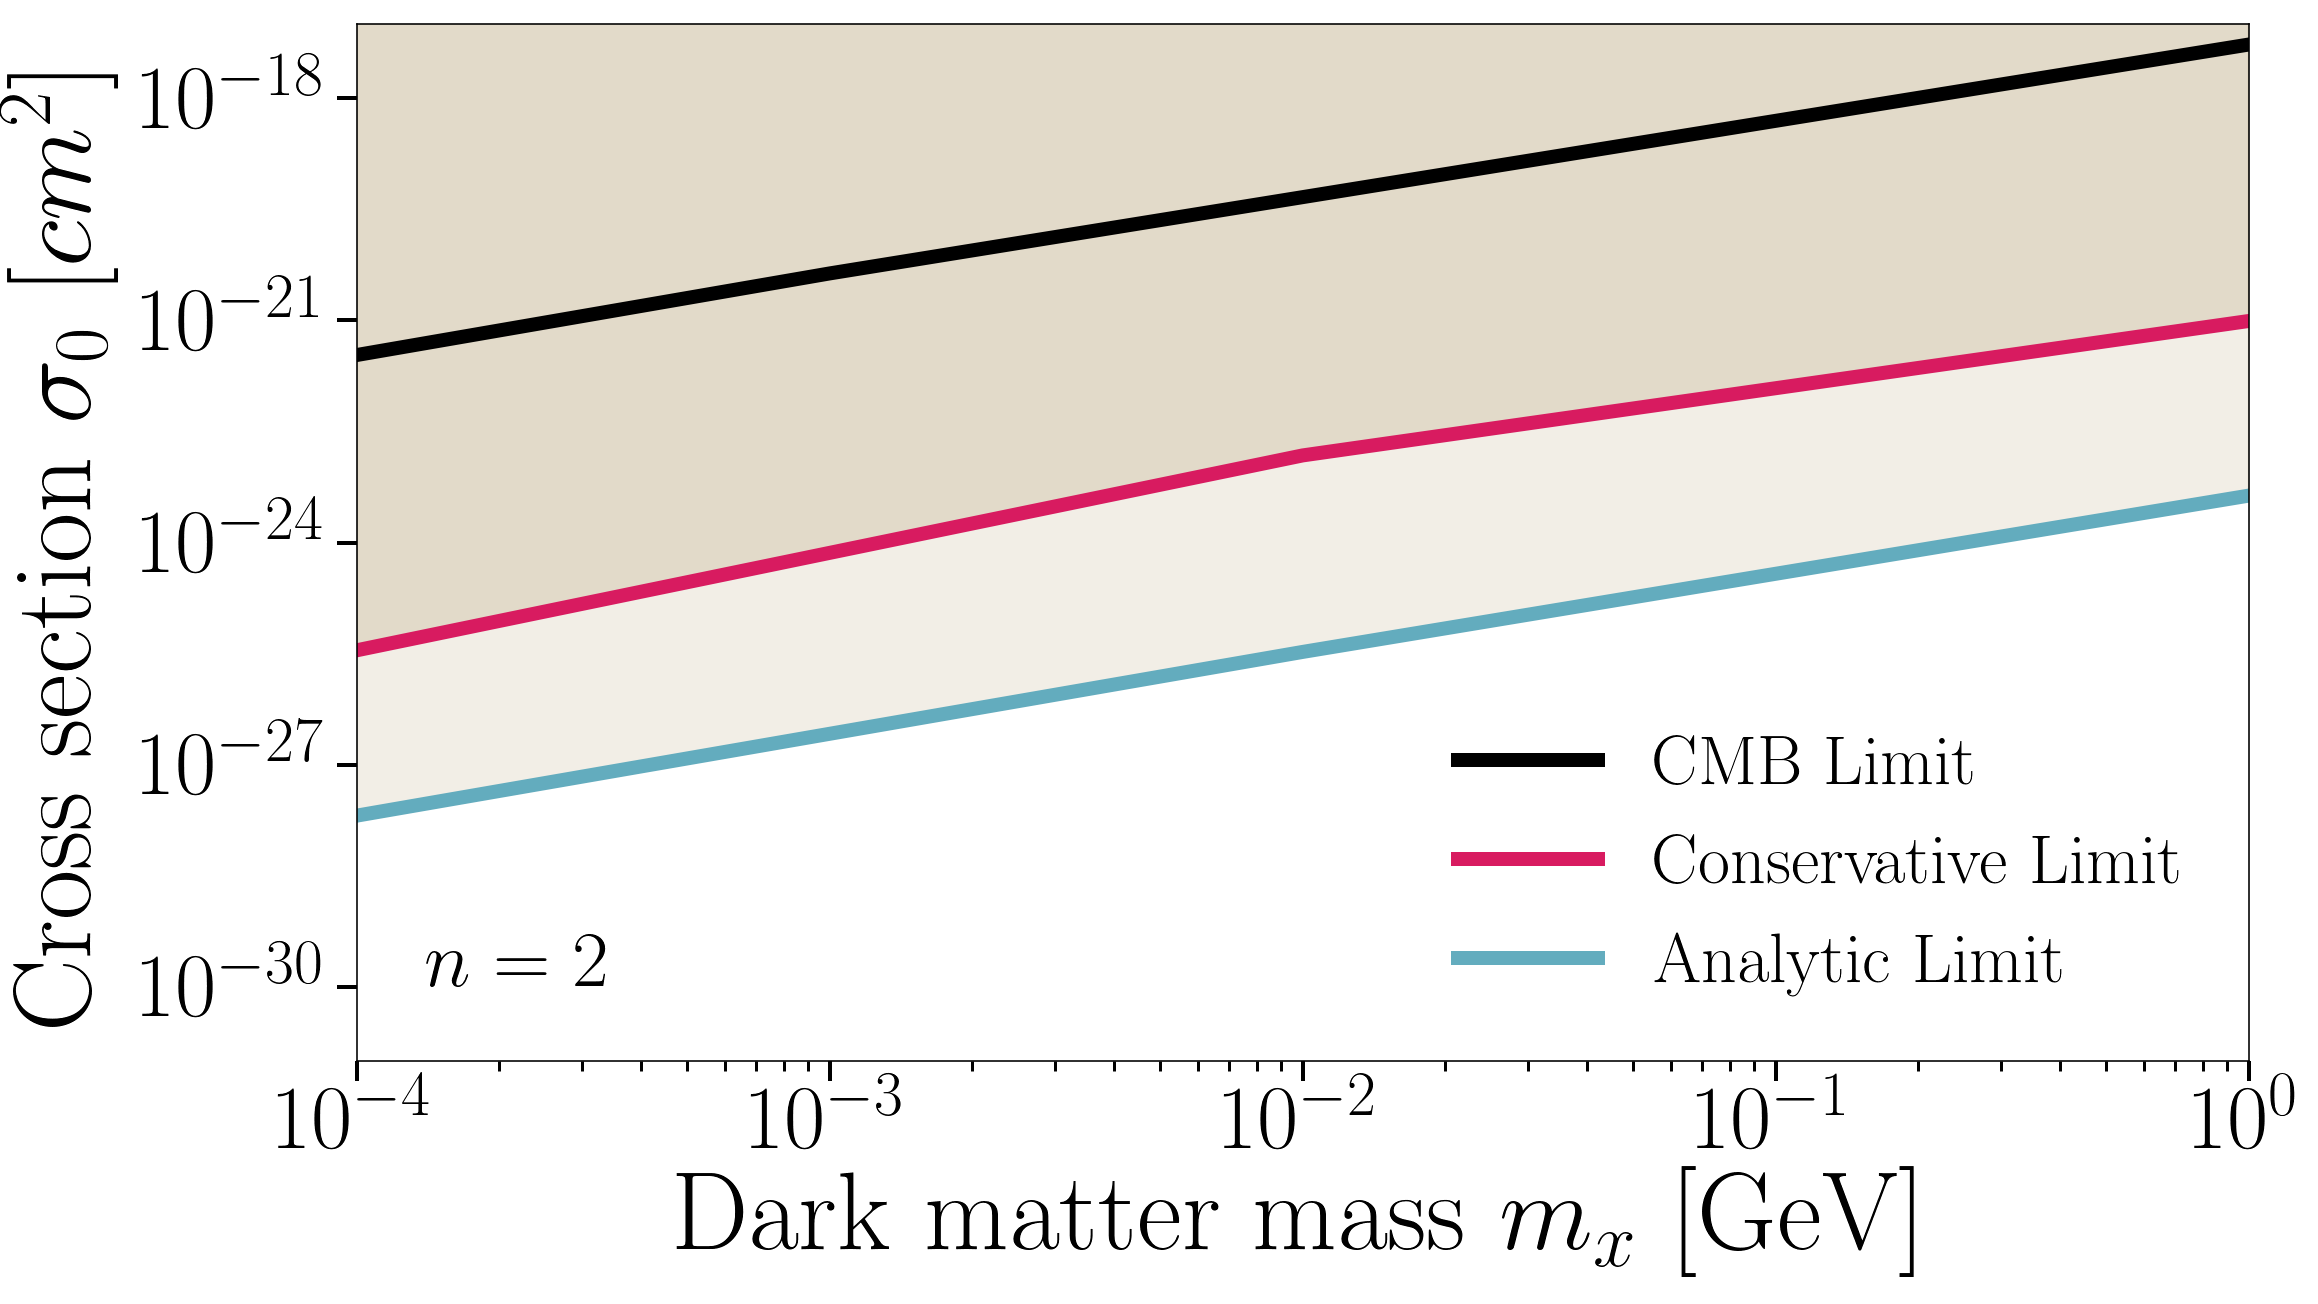

In [31]:
sigs0_prog = [1e-29,2.6e-29,1e-28]
sigs2_prog = [1.7e-27,3.6e-25,3.8e-23]
sigs4_prog = [5.6e-26,1.2e-21,5.3e-18]
sigs6_prog = [9.1e-25,2.8e-18,6e-13]

sigs0_cons = [1e-28,4.2e-28,2.7e-27]
sigs2_cons = [3.5e-26,7.4e-24,1.2e-21]
sigs4_cons = [3.7e-24,8.1e-20,3.5e-16]
sigs6_cons = [2.4e-22,3.6e-16,8e-11]

sigs2_uberCons = [3.5e-26,1.5e-23,9.8e-22]
sigs4_uberCons = [4.6e-24,8.3e-19,1.45e-15]
sigs6_uberCons = [3.1e-22,9.3e-14,1.6e-9]

sigs0_anal = [2e-29,6.4e-29,4.1e-28]
sigs2_anal = [sig(klim,2.)[0],sig(klim,2.)[2],sig(klim,2.)[4]]
sigs4_anal = [sig(klim,4.)[0],sig(klim,4.)[2],sig(klim,4.)[4]]
sigs6_anal = [sig(klim,6.)[0],sig(klim,6.)[2],sig(klim,6.)[4]]

sigs0_eft = [8.8e-27,2.6e-26,1.5e-25,1.4e-23]
sigs2_eft = [4.2e-23,4.3e-21,5.3e-18,2.2e-15]
sigs4_eft = [1.6e-20,1.0e-16,4.1e-11,9.3e-09]
sigs6_eft = [5.0e-04,1.5e+00]

mass = [0.0001,0.01,1]
mass_eft = [1.5e-5,0.001,1,1000]
mass_eft6 = [1,1000]

plt.figure(figsize=(18,10))

# plt.loglog(mass,sigs0_prog,label="n=0, progressive",linestyle='-',color='lightsteelblue',lw=3)
# plt.loglog(mass_eft,sigs0_eft,label="n=0, eft",linestyle='-',color='khaki',lw=3)

# plt.loglog(mass,sigs2_prog,label="n=2, Progressive",linestyle='-',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,7e-24,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
plt.loglog(mass_eft,sigs2_eft,label="CMB Limit",linestyle='-',color='black',lw=7)
plt.loglog(mass,sigs2_uberCons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
plt.loglog(mass, sigs2_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
plt.fill_between(mass, sigs2_anal, 1, color='#ccbe9f', alpha=0.25)
plt.fill_between(mass, sigs2_uberCons, 1, color='#ccbe9f', alpha=0.4)
plt.text(1.4e-4,1e-30,"$n=2$",fontsize=40)
plt.yticks([1e-30,1e-27,1e-24,1e-21,1e-18],["$10^{-30}$","$10^{-27}$","$10^{-24}$","$10^{-21}$","$10^{-18}$"])
plt.ylim(1e-31,1e-17)

# plt.loglog(mass,sigs4_prog,label="n=4, Progressive",linestyle='-.',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,1e-14,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
# plt.loglog(mass_eft,sigs4_eft,label="CMB Limit",linestyle='-',color='black',lw=7)
# plt.loglog(mass,sigs4_uberCons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
# plt.loglog(mass, sigs4_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
# plt.fill_between(mass, sigs4_anal, 1, color='#ccbe9f', alpha=0.25)
# plt.fill_between(mass, sigs4_uberCons, 1, color='#ccbe9f', alpha=0.4)
# plt.text(1.4e-4,1e-29,"$n=4$",fontsize=40)
# plt.yticks([1e-29,1e-26,1e-23,1e-20,1e-17],["$10^{-29}$","$10^{-26}$","$10^{-23}$","$10^{-20}$","$10^{-17}$"])
# plt.ylim(1e-31,1e-10)

# plt.loglog(mass,sigs6_prog,label="progressive",linestyle=':',color='lightsteelblue',lw=3)
# plt.text(1.6e-4,1e-13,"Excluded by\n Milky Way Satellites",fontsize=30,alpha=0.9)
# plt.loglog(mass_eft6,sigs6_eft,label="eft",linestyle='-',color='black',lw=7)
# plt.loglog(mass,sigs6_uberCons,label="Conservative Limit",linestyle='-',color='#D81B60',lw=7)
# plt.loglog(mass, sigs6_anal, label="Analytic Limit",lw=7,linestyle='-',color='#63acbe')
# plt.fill_between(mass, sigs6_anal, 1, color='#ccbe9f', alpha=0.25)
# plt.fill_between(mass, sigs6_uberCons, 1, color='#ccbe9f', alpha=0.4)
# plt.text(1.4e-4,1e-29,"$n=6$",fontsize=40)
# plt.yticks([1e-29,1e-26,1e-23,1e-20,1e-17,1e-14,1e-11,1e-8],["$10^{-29}$","$10^{-26}$","$10^{-23}$","$10^{-20}$","$10^{-17}$","$10^{-14}$","$10^{-11}$","$10^{-8}$"])
# plt.ylim(1e-31,1e-7)

plt.xlim(1e-4,1)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=55,labelpad=5)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]",fontsize=55,labelpad=5)
plt.legend(fontsize=35,loc='lower right',framealpha=0)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)

plt.subplots_adjust(left=0.17,bottom=0.16)
plt.savefig("plots/limits/limits_n2_CAE.png")
# plt.savefig("plots/limits/limits_n4_CAE.png")
# plt.savefig("plots/limits/limits_n6_CAE.png")

In [32]:
n2_limits = pd.DataFrame({'Mass (GeV)':mass,
                          '$\sigma_0$ super conservative ($cm^2$)':sigs2_uberCons,
                          '$\sigma_0$ analytical ($cm^2$)':sigs2_anal})
# n2_limits.to_csv("n2_limits.csv")
n2_limits

$\sigma_0$ analytical ($cm^2$)  $\sigma_0$ super conservative ($cm^2$)  \
0                    2.049075e-28                            3.500000e-26   
1                    3.331295e-26                            1.500000e-23   
2                    4.297005e-24                            9.800000e-22   

   Mass (GeV)  
0      0.0001  
1      0.0100  
2      1.0000

In [33]:
n4_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ super conservative ($cm^2$)':sigs4_uberCons,'$\sigma_0$ analytical ($cm^2$)':sigs4_anal})
# n4_limits.to_csv("n4_limits.csv")
n4_limits

$\sigma_0$ analytical ($cm^2$)  $\sigma_0$ super conservative ($cm^2$)  \
0                    1.644676e-27                            4.600000e-24   
1                    2.171118e-23                            8.300000e-19   
2                    1.135733e-19                            1.450000e-15   

   Mass (GeV)  
0      0.0001  
1      0.0100  
2      1.0000

In [34]:
n6_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ super conservative ($cm^2$)':sigs6_uberCons,'$\sigma_0$ analytical ($cm^2$)':sigs6_anal})
# n4_limits.to_csv("n4_limits.csv")
n6_limits

$\sigma_0$ analytical ($cm^2$)  $\sigma_0$ super conservative ($cm^2$)  \
0                    6.593188e-27                            3.100000e-22   
1                    8.907355e-21                            9.300000e-14   
2                    1.889652e-15                            1.600000e-09   

   Mass (GeV)  
0      0.0001  
1      0.0100  
2      1.0000

---

---

---

# Plots/Analysis (tk/DAOs)

#### Transfer function business

5.462277217684337e-18
((246,), (246,), (246,))


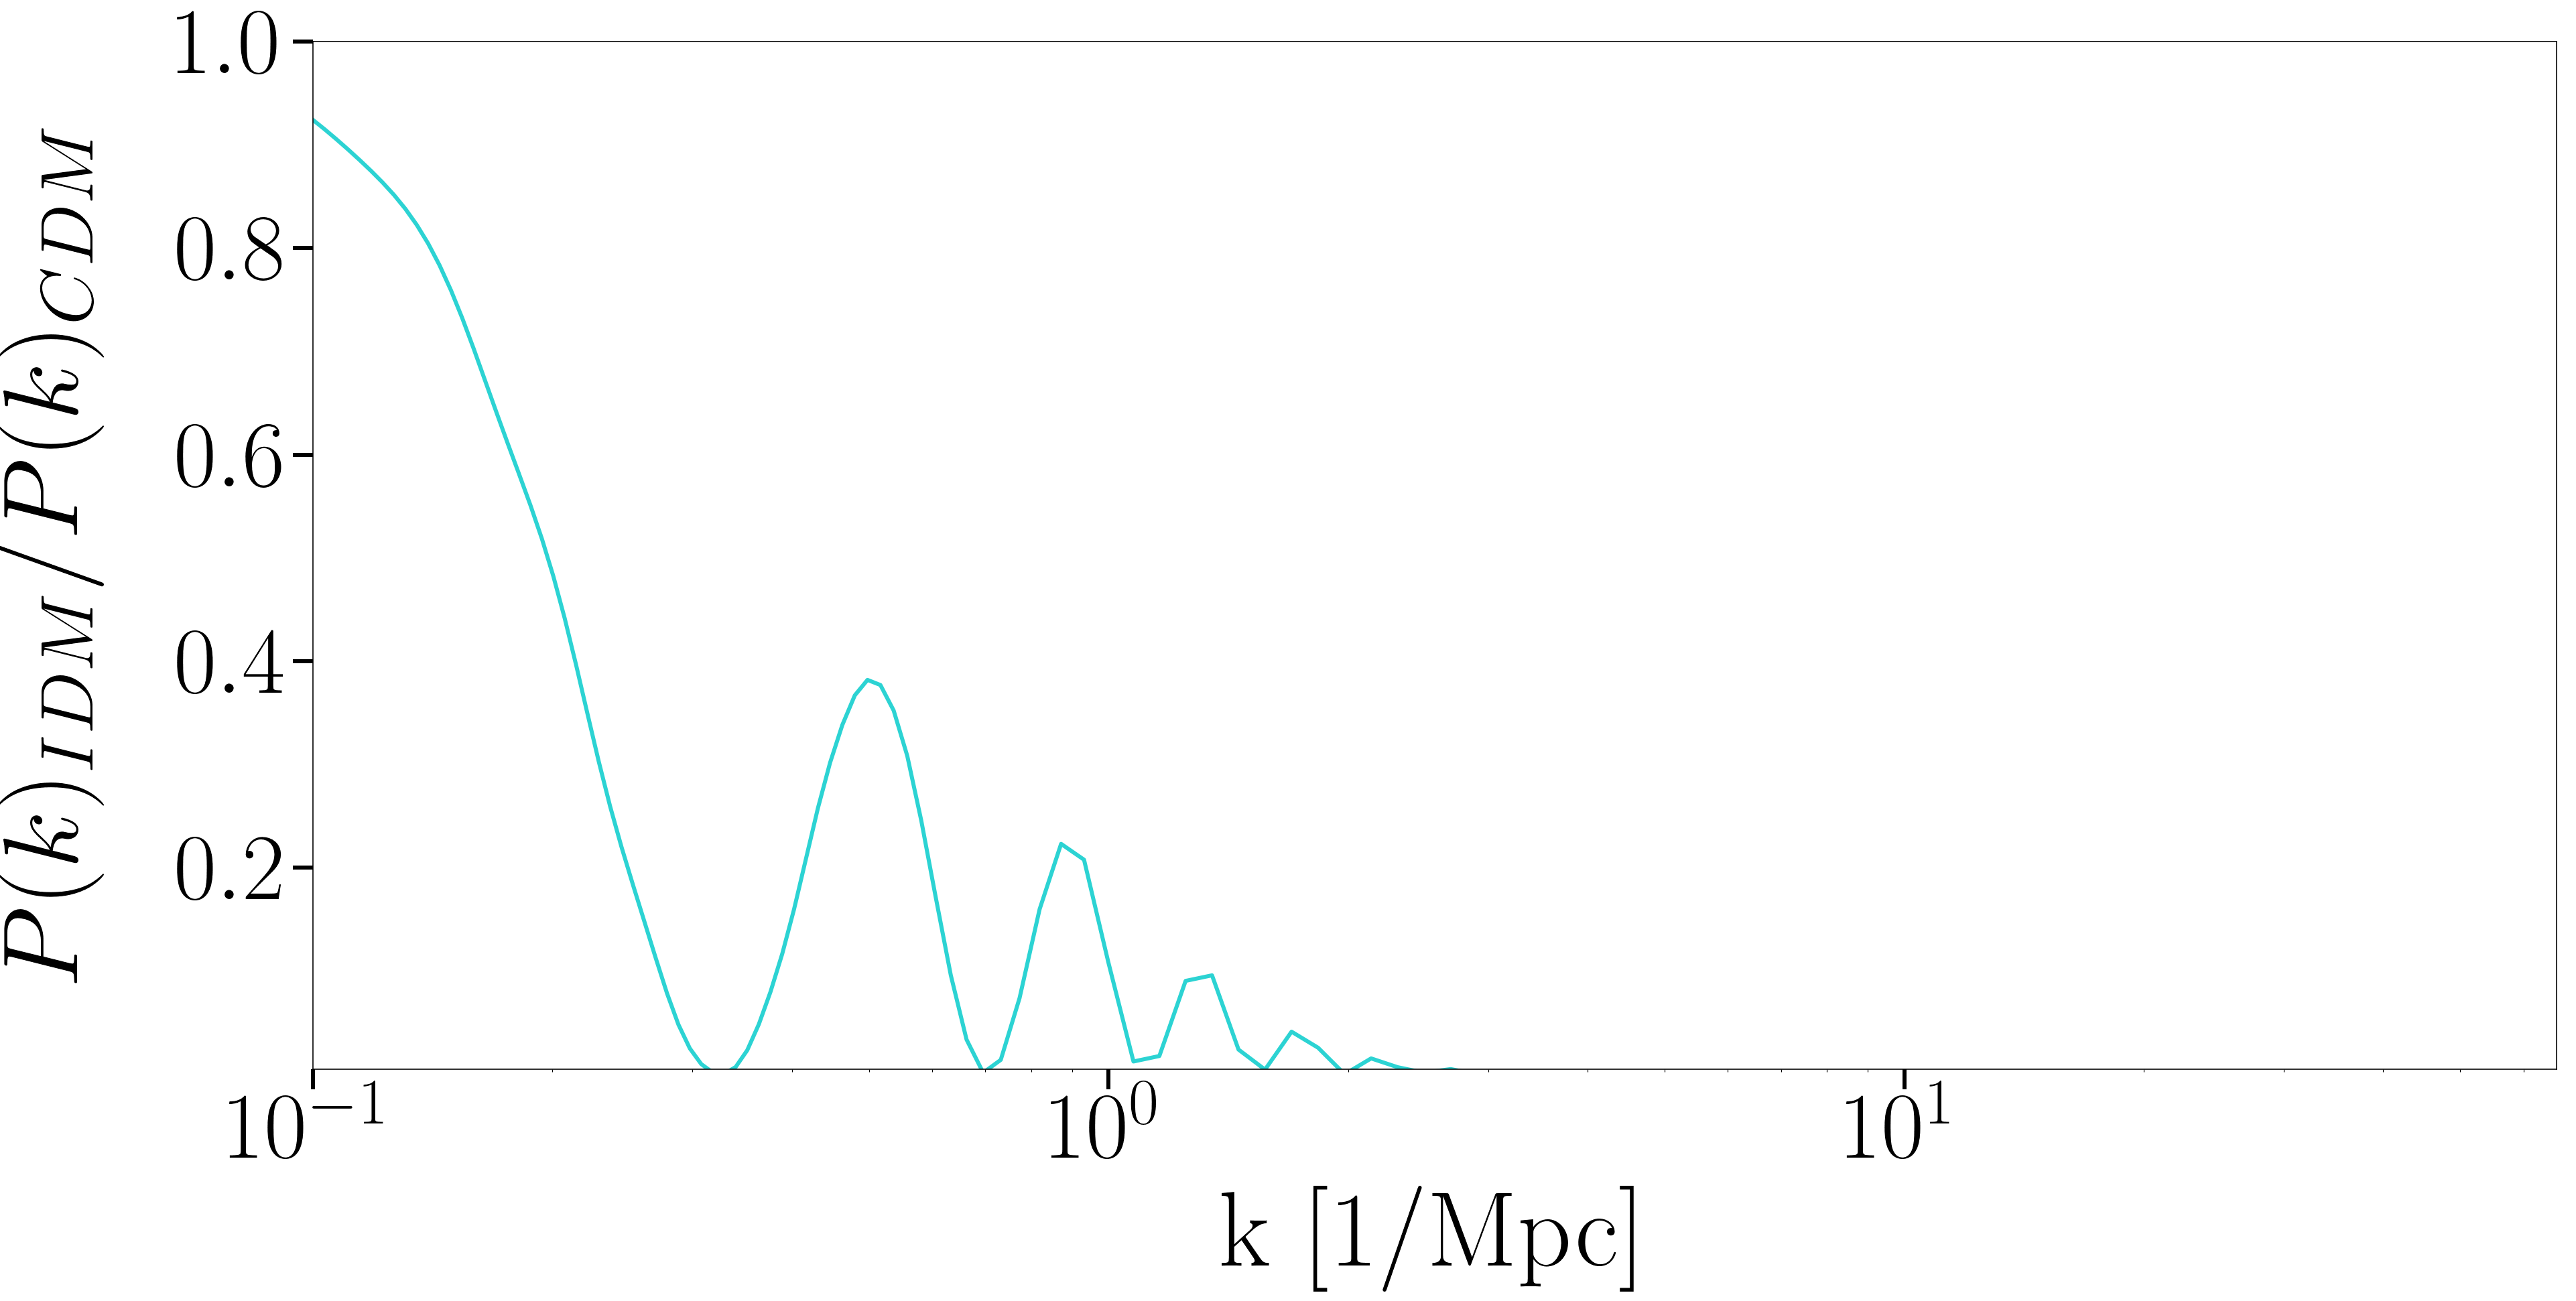

In [35]:
plt.figure(figsize=(30,15))    
plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0.005,1)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80)
plt.tick_params(labelsize=70,length=15,width=3)

# tks,ks,sgma = single_tk(colorbar=True,npow=0,label="n=0",sigmas=smallSigs,index=20,lw=3)
tks,ks,sgma = single_tk(npow=4,label="n=2",sigmas=smallSigs2,index=2,lw=3)
# tks,ks,sgma = single_tk(colorbar=True,npow=4,label="n=4",sigmas=smallSigs,index=20,lw=3)
# tks,ks,sgma = single_tk(colorbar=True,npow=6,label="n=6",sigmas=smallSigs,index=20,lw=3)

# plt.axvline(12,lw=10)

# plt.legend(fontsize=58)

plt.subplots_adjust(bottom=0.17)
# plt.savefig("plots/tk/tk_all_n2.png",dpi=200)

In [36]:
# Constants
h = 0.6727
H0 = 67.27
Omega_m = 0.26495
Omega_b = 0.05
Omega_rad = 1e-5
p_crit = 4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p = 0.93827231
Y_p = 0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
Rx_conerverionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

(0.1, 66)

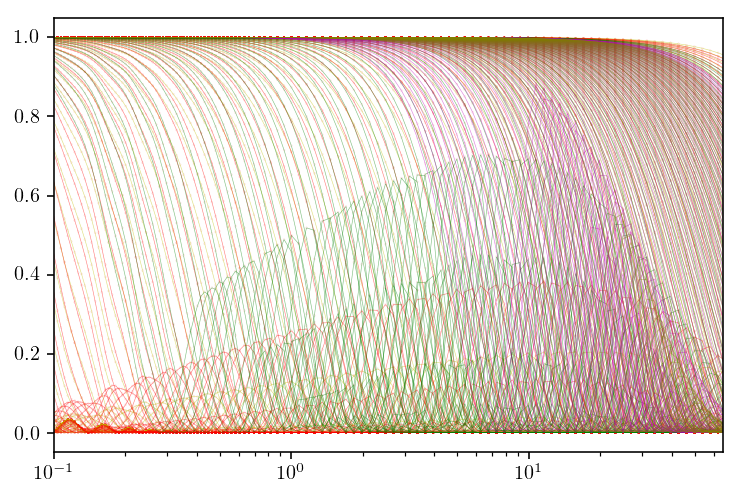

In [37]:
all_tk(npow=1,m=0.0001,sigmas=smallSigs2)
all_tk(npow=2,m=0.0001,sigmas=smallSigs2)
# all_tk(npow=3,m=0.0001,sigmas=smallSigs2)
all_tk(npow=4,m=0.0001,sigmas=smallSigs2)
all_tk(npow=5,m=0.0001,sigmas=smallSigs2)
all_tk(npow=6,m=0.0001,sigmas=smallSigs)
all_tk(npow=8,m=0.0001,sigmas=smallSigs)
all_tk(npow=10,m=0.0001,sigmas=smallSigs)

plt.xlim(1e-1,66)

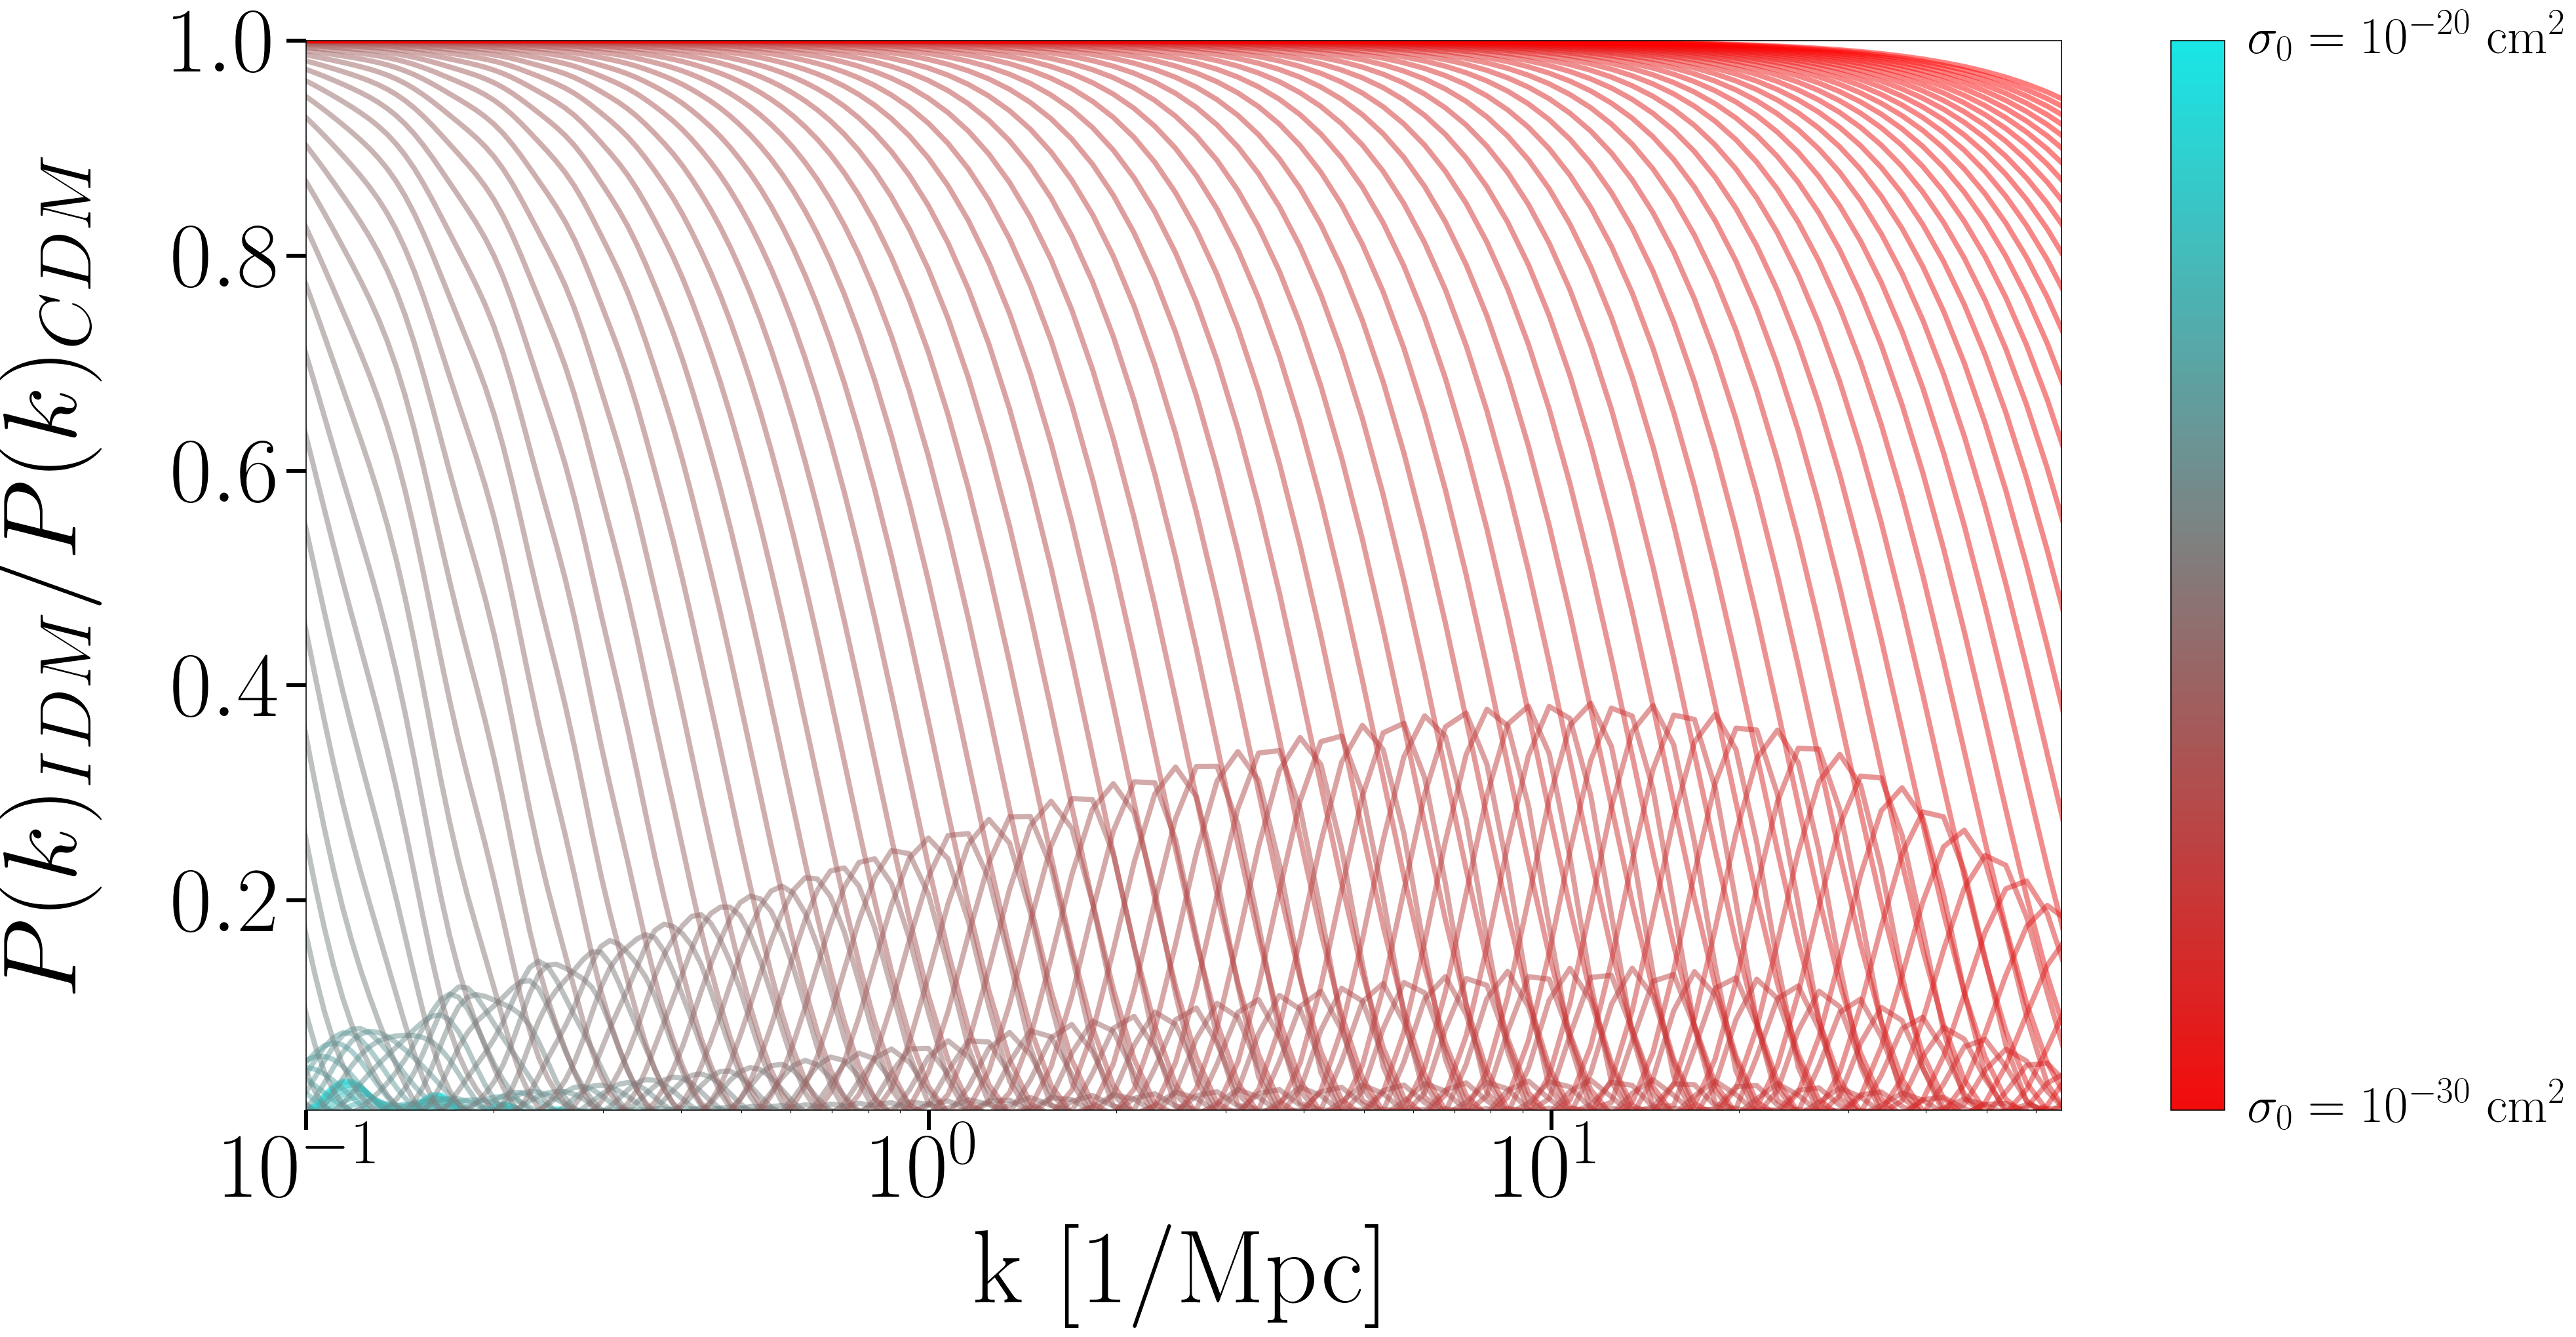

In [38]:
plt.figure(figsize=(30,15))    
plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0.005,1)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80)
plt.tick_params(labelsize=70,length=15,width=3)

all_tk(colorbar=True,npow=2,m=0.0001,sigmas=smallSigs2,lw=4)

In [39]:
# k1,tk1,s1 = peaks(npow=1)
k2,tk2,s2 = peaks(npow=2)
# k3,tk3,s3 = peaks(npow=3)
k4,tk4,s4 = peaks(npow=4)
# k5,tk5,s5 = peaks(npow=5)
k6,tk6,s6 = peaks(npow=6,sigmas=smallSigs)
k8,tk8,s8 = peaks(npow=8,sigmas=smallSigs)
# k10,tk10,s10 = peaks(npow=10,sigmas=smallSigs)

# FIT ONE

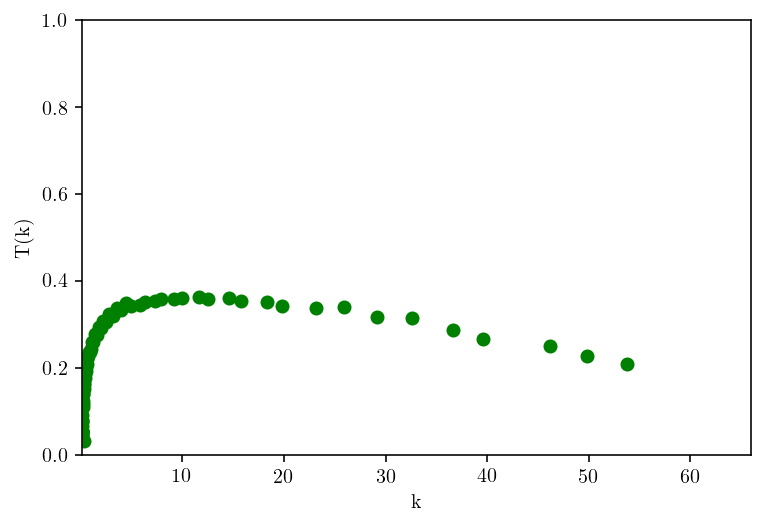

In [47]:
for i in range(len(tk2)):
    plt.scatter(k2[i][0],tk2[i][0],c='g')

plt.scatter(k2[0][0],tk2[0][0],c='g',label='n=3')
# plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
# plt.legend()
all_tk(npow=3,m=0.0001,sigmas=smallSigs2,lw=0.7)
# plt.text(3e-1,-0.27,"Plot of all discernible peaks. n=3 used as example.\n Plotted for $k$. Tk for all sigmas overlaid")

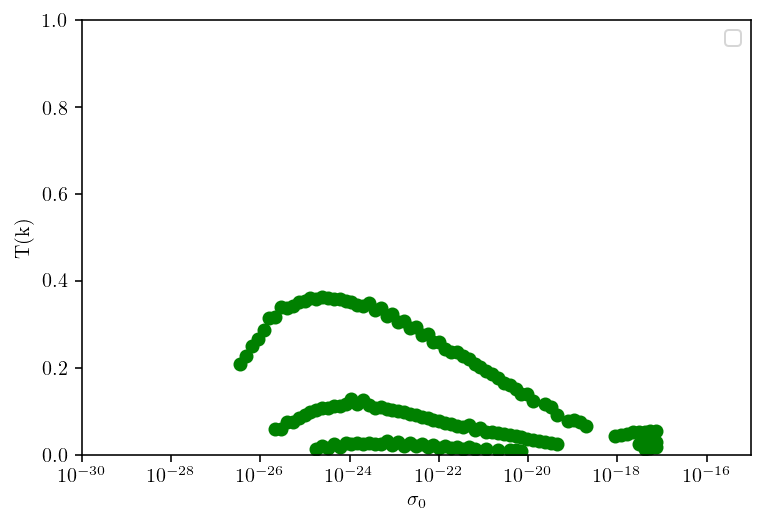

In [41]:
for i in range(len(tk2)):
    for j in range(len(tk2[i])):
        try: plt.scatter(s2[i],tk2[i][j],c='g')
        except: continue

# plt.scatter(s3[0],tk3[0][0],c='g',label='n=3')
plt.xscale('log')
plt.xlim(1e-30,1e-15)
plt.ylim(0,1)
plt.xlabel("$\sigma_0$")
plt.ylabel("T(k)")
plt.legend()
# plt.text(1e-25,-0.27,"Plot of all discernible peaks. n=3 used as example.\n Plotted for $sigma_0$.")

In [42]:
relatives1 = []
relatives2 = []
relatives3 = []
relatives4 = []
relatives5 = []

for i in range(len(tk2)):
    try: 
#         relatives1.append([tk1[i][0]/tk1[i][1]])
        relatives2.append([tk2[i][0]/tk2[i][1]])
#         relatives3.append([tk3[i][0]/tk3[i][1]])
#         relatives4.append([tk4[i][0]/tk4[i][1]])
#         relatives5.append([tk5[i][0]/tk5[i][1]])
    except: continue

Text(0.3,-2.25,'First to second peak ratio for n=1-5. Plotted for k.')

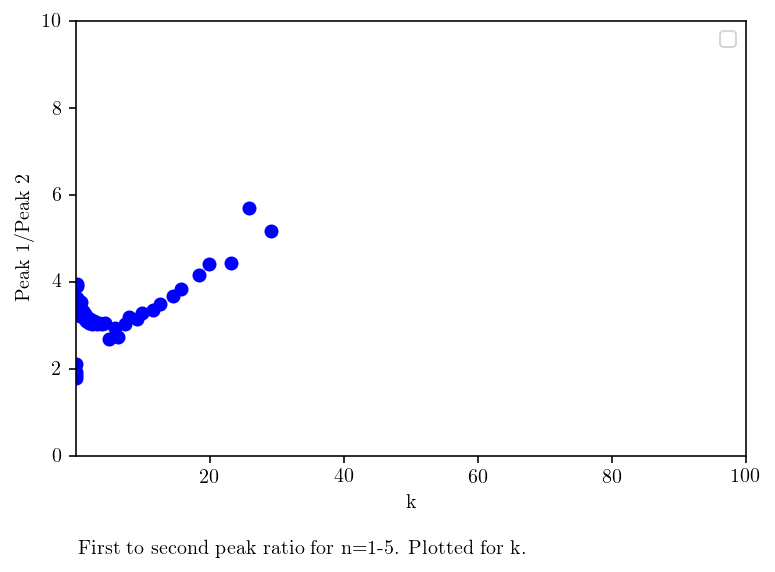

In [43]:
for i in range(len(relatives2)):
    try:
#         plt.scatter(k1[i][0],relatives1[i][0],c='k')
        plt.scatter(k2[i][0],relatives2[i][0],c='b')
#         plt.scatter(k3[i][0],relatives3[i][0],c='g')
#         plt.scatter(k4[i][0],relatives4[i][0],c='r')
#         plt.scatter(k5[i][0],relatives5[i][0],c='y')
    except: continue

# plt.scatter(k1[0][0],relatives1[0][0],c='k',label='n1')
# plt.scatter(k2[0][0],relatives2[0][0],c='b',label='n2')
# plt.scatter(k3[0][0],relatives3[0][0],c='g',label='n3')
# plt.scatter(k4[0][0],relatives4[0][0],c='r',label='n4')
# plt.scatter(k5[0][0],relatives5[0][0],c='y',label='n5')
# plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(0,10)
plt.xlabel("k")
plt.ylabel("Peak 1/Peak 2")
plt.legend()
plt.text(3e-1,-2.25,"First to second peak ratio for n=1-5. Plotted for k.")

In [44]:
for i in range(len(relatives1)):
    try:
        plt.scatter(s1[i],relatives1[i][0],c='k')
        plt.scatter(s2[i],relatives2[i][0],c='b')
        plt.scatter(s3[i],relatives3[i][0],c='g')
        plt.scatter(s4[i],relatives4[i][0],c='r')
        plt.scatter(s5[i],relatives5[i][0],c='y')
    except: continue

plt.scatter(s1[0],relatives1[0][0],c='k',label='n1')
plt.scatter(s2[0],relatives2[0][0],c='b',label='n2')
plt.scatter(s3[0],relatives3[0][0],c='g',label='n3')
plt.scatter(s4[0],relatives4[0][0],c='r',label='n4')
plt.scatter(s5[0],relatives5[0][0],c='y',label='n5')
plt.xscale('log')
plt.xlim(1e-26,1e-20)
plt.ylim(0,10)
plt.xlabel("k")
plt.ylabel("Peak 1/Peak 2")
plt.legend()
# plt.text(3e-1,-2.25,"First to second peak ratio for n=1-5. Plotted for k.")

NameError: name 's1' is not defined

In [ ]:
for i in range(len(k1)):
    plt.scatter(k1[i][0],tk1[i][0],c='k')
    plt.scatter(k2[i][0],tk2[i][0],c='b')
    plt.scatter(k3[i][0],tk3[i][0],c='g')
    plt.scatter(k4[i][0],tk4[i][0],c='r')
    plt.scatter(k5[i][0],tk5[i][0],c='y')
    plt.scatter(k6[i][0],tk6[i][0],c='m')
    plt.scatter(k10[i][0],tk10[i][0],c='c')

plt.scatter(k1[3][0],tk1[3][0],c='k',label='n1')
plt.scatter(k2[22][0],tk2[22][0],c='b',label='n2')
plt.scatter(k3[23][0],tk3[23][0],c='g',label='n3')
plt.scatter(k4[17][0],tk4[17][0],c='r',label='n4')
plt.scatter(k5[9][0],tk5[9][0],c='y',label='n5')
plt.scatter(k6[1][0],tk6[1][0],c='m',label='n6')
plt.scatter(k10[1][0],tk10[1][0],c='c',label='n10')
plt.xscale('log')
plt.xlim(5e-2,1e2)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.legend()
plt.text(9e-2,-0.3,"Plot of first peak amplitude for n=1-6 (black=1 ... magenta=6).\n Limited by issues with class. Outliers due to localMax function.\n Fall faster w/ increased n (cyan=10). Fig. 1 in ETHOS?")

In [ ]:
plt.scatter(k1[3][0],tk1[3][0],c='k',label='n1')
plt.scatter(k2[22][0],tk2[22][0],c='b',label='n2')
plt.scatter(k3[23][0],tk3[23][0],c='g',label='n3')
plt.scatter(k4[17][0],tk4[17][0],c='r',label='n4')
plt.scatter(k5[9][0],tk5[9][0],c='y',label='n5')
plt.scatter(k6[1][0],tk6[1][0],c='m',label='n6')
plt.scatter(k8[1][0],tk8[1][0],c='olive',label='n8')
plt.scatter(k10[1][0],tk10[1][0],c='c',label='n10')

plt.xscale('log')
plt.xlim(5e-2,1e2)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.legend()
plt.text(1.1e-1,-0.3,"Plot of first peak amplitude for n=1-10 (black=1 ... cyan=10)\n at similar $\sigma_0$ (8e-21). Larger ns are further along in\n evolution. n=10 almost done compared to n=1 just started")

---

---

---

$\Huge{\frac{log(k+2.3)}{\alpha*1.09^{kn/10}}}$

# Parameter fitting

In [120]:
a2 = 2.35480485e+09
b2 = 4.23837346e-01
a4 = 4e+07
b4 = 4.1e-01

params2_1st = [2.3,2,1.09,10]
params4_1st = [2.3,4,1.09,5]
params6_1st = [2.3,6,1.09,3.3]
params8_1st = [2.3,8.,1.09,2]

params2_2nd = [2.3,2,1.09,35]
params4_2nd = [2.3,4,1.09,10]
params6_2nd = [1.5,6,1.09,3.3]
params8_2nd = [2.3,8.,1.09,2]

In [49]:
def A(x,a,b):
    return a*pow(x,b)

In [50]:
def exponential(x,a,b):
    return b*np.exp((-a*x))

In [51]:
def murg(k,a,b,c):
    return (1+(a*k)**b)**c

In [52]:
def logpow(x,a,npow,n,m):
    aa = (np.log(x)+a)/(m*np.power(n,(x*npow)/10))
    return (aa)

In [53]:
fit_k2 = [row[0] for row in k2]
fit_tk2 = [row[0] for row in tk2]
fit_k4 = np.array([row[0] for row in k4])
fit_tk4 = np.array([row[0] for row in tk4])
fit_k6 = [row[0] for row in k6]
fit_tk6 = [row[0] for row in tk6]
fit_k8 = [row[0] for row in k8]
fit_tk8 = [row[0] for row in tk8]

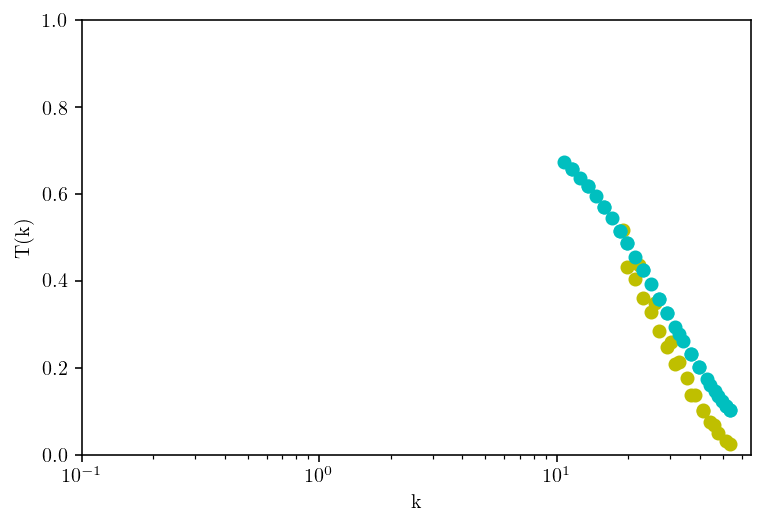

In [121]:
# for i in range(len(tk2)):
#     plt.scatter(k2[i][0],tk2[i][0],c='r')
# for i in range(len(tk4)):
#     plt.scatter(k4[i][0],tk4[i][0],c='b')
# for i in range(len(tk6)):
#     plt.scatter(k6[i][0],tk6[i][0],c='y')    
# for i in range(len(tk8)):
#     plt.scatter(k8[i][0],tk8[i][0],c='g')

# for i in range(len(tk2)):
#     plt.scatter(k2[i][0],tk2[i][0],c='r')
# for i in range(len(tk4)):
#     plt.scatter(k4[i][1],tk4[i][1],c='b')
for i in range(len(tk6)):
    plt.scatter(k6[i][1],tk6[i][1],c='y')    
# for i in range(len(tk8)):
#     plt.scatter(k8[i][0],tk8[i][0],c='g')

plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.xscale('log')

# xs = np.logspace(-1, 2, num=50)
    
# for i in range(len(tk2)):
#     plt.scatter(fit_k2[i],logpow(np.array(fit_k2[i]),*params2_2nd),c='c')
# for i in range(len(tk4)):
#     plt.scatter(fit_k4[i],logpow(np.array(fit_k4[i]),*params4_2nd),c='c')
for i in range(len(tk6)):
    plt.scatter(fit_k6[i],logpow(np.array(fit_k6[i]),*params6_2nd),c='c')
# for i in range(len(tk8)):
#     plt.scatter(fit_k8[i],logpow(np.array(fit_k8[i]),*params8_2nd),c='c')   

# plt.text(3e-1,-0.3,"Estimated first peak evolution with k")

In [ ]:
n2_idx1 = (7.924828983539186e-21,7)
n2_idx5 = (3.1257158496882354e-21,5)
n2_idx10 = (9.770099572992246e-22,3)
n2_idx15 = (3.0538555088334124e-22,1.7)
n2_idx20 = (9.545484566618328e-23,1)
n2_idx25 = (2.983647240283334e-23,0.6)
n2_idx30 = (9.32603346883218e-24,0.4)
n2_idx35 = (2.9150530628251697e-24,0.23)
n2_idx40 = (9.111627561154867e-25,0.14)
n2_idx45 = (2.848035868435793e-25,0.09)
n2_fit_sigma = [i1[0],i2[0],i3[0],i4[0],i10[0],i15[0],n2_idx45[0],n2_idx40[0],n2_idx35[0],n2_idx30[0],n2_idx25[0],n2_idx20[0],n2_idx15[0],n2_idx10[0],n2_idx5[0],n2_idx1[0]]
n2_fit_factor = [i1[1],i2[1],i3[1],i4[1],i10[1],i15[1],n2_idx45[1],n2_idx40[1],n2_idx35[1],n2_idx30[1],n2_idx25[1],n2_idx20[1],n2_idx15[1],n2_idx10[1],n2_idx5[1],n2_idx1[1]]

In [ ]:
n4_idx1 = (7.924828983539186e-21,0.17,1.15)
n4_idx5 = (3.1257158496882354e-21,1.4,1.1)
n4_idx10 = (9.770099572992246e-22,0.85,1.1)
n4_idx15 = (3.0538555088334124e-22,0.5,1.08)
n4_idx20 = (9.545484566618328e-23,0.30,1.07)
n4_idx25 = (2.983647240283334e-23,0.16,1.05)
# n4_idx30 = (9.32603346883218e-24,0.43,1.15)
# n4_idx35 = (2.9150530628251697e-24,0.27,1.15)
# n4_idx40 = (9.111627561154867e-25,0.17,1.15)
# n4_idx45 = (2.848035868435793e-25,0.11,1.15)
n4_idx50 = (8.902150854450356e-26,0.07,1.15)
n4_fit_sigma = [n4_idx25[0],n4_idx20[0],n4_idx15[0],n4_idx10[0]]
n4_fit_factor = [n4_idx25[1],n4_idx20[1],n4_idx15[1],n4_idx10[1]]
n4_fit_factor2 = [n4_idx50[2],n4_idx45[2],n4_idx40[2],n4_idx35[2],n4_idx30[2],n4_idx25[2],n4_idx20[2],n4_idx15[2],n4_idx10[2]]

In [ ]:
plt.xscale('log')
plt.xlim(1e-3,66)
plt.ylim(0,1.5)
tks,ks,sgma = single_tk(npow=4,label="n=2",sigmas=smallSigs2,index=20,lw=1)
for i in range(len(ks)):
    plt.scatter(ks[i],exponential(ks[i],0.3,1.07),s=0.5)

log(x) doesn't work because it is linear in logspace

In [ ]:
plt.scatter(fit_sigma,fit_factor)
for i in range(len(fit_sigma)):
    plt.scatter(fit_sigma[i],A(fit_sigma[i],a2,b2),s=3)
plt.xscale('log')
plt.xlim(1e-25,1e-17)
# plt.ylim(0,40)